In [2]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import matplotlib.pyplot as plt
import time
import os
import pandas as pd
from PIL import Image
from torch.utils.data import Dataset
import torchvision.transforms as transforms

In [3]:
# Define transformations for CIFAR-10 dataset
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),  # Randomly flip the image horizontally
    transforms.RandomCrop(32, padding=4),  # Randomly crop the image to size 32x32 with padding of 4 pixels
    transforms.ToTensor(),  # Convert the image to a PyTorch tensor
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize the image with mean and standard deviation
])

# Download and load the CIFAR-10 dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

# Define batch size for training
batch_size = 64

# Create data loaders
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

# Define classes in CIFAR-10
classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

# Check the number of images
print(f"Number of training images: {len(trainset)}")
print(f"Number of test images: {len(testset)}")


Files already downloaded and verified
Files already downloaded and verified
Number of training images: 50000
Number of test images: 10000


ResNet-18 using pytorch

/opt/anaconda3/envs/umit/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/envs/umit/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch Count [1/25], Training Loss: 1.7544, Training Accuracy: 35.41%, Validation Loss: 1.5399, Validation Accuracy: 43.00%
Epoch Count [2/25], Training Loss: 1.4663, Training Accuracy: 46.17%, Validation Loss: 1.3521, Validation Accuracy: 50.93%
Epoch Count [3/25], Training Loss: 1.3388, Training Accuracy: 51.52%, Validation Loss: 1.2924, Validation Accuracy: 53.16%
Epoch Count [4/25], Training Loss: 1.2387, Training Accuracy: 55.42%, Validation Loss: 1.2130, Validation Accuracy: 55.96%
Epoch Count [5/25], Training Loss: 1.1633, Training Accuracy: 58.38%, Validation Loss: 1.0995, Validation Accuracy: 60.87%
Epoch Count [6/25], Training Loss: 1.0993, Training Accuracy: 60.89%, Validation Loss: 1.0664, Validation Accuracy: 61.72%
Epoch Count [7/25], Training Loss: 1.0477, Training Accuracy: 62.58%, Validation Loss: 1.0449, Validation Accuracy: 63.23%
Epoch Count [8/25], Training Loss: 0.9978, Training Accuracy: 64.28%, Validation Loss: 0.9930, Validation Accuracy: 64.61%
Epoch Count [9/2

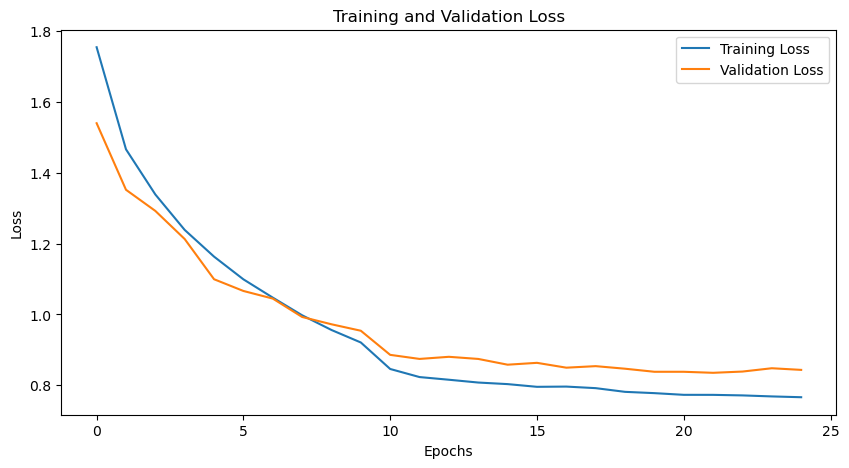

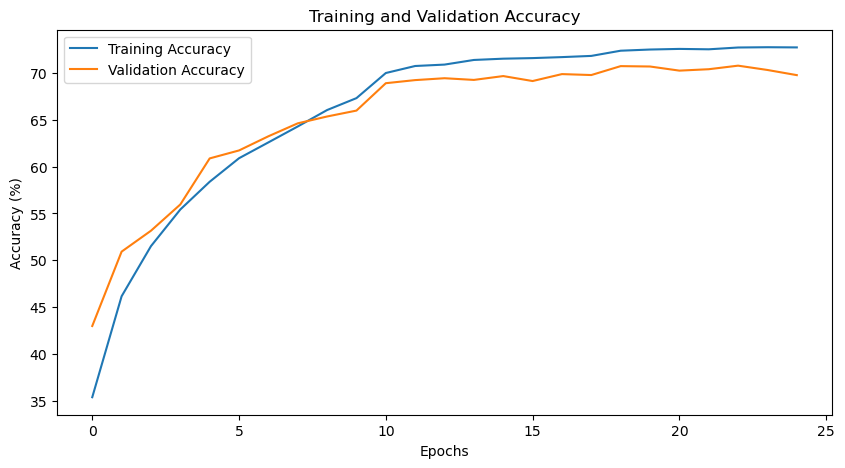

In [4]:
# Define ResNet-18 model
class ResNet18(nn.Module):
    def __init__(self, num_classes=10):
        super(ResNet18, self).__init__()
        self.resnet = torchvision.models.resnet18(pretrained=False)
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, num_classes)  # Replace classifier with CIFAR-10 classes

    def forward(self, x):
        return self.resnet(x)

# Initialize your ResNet-18 model
resnet18 = ResNet18()

# Define Loss Function and Optimizer
criterion = nn.CrossEntropyLoss()  # Cross-entropy loss for multi-class classification
optimizer = optim.SGD(resnet18.parameters(), lr=0.001, momentum=0.9)  # SGD optimizer with momentum

# Define learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

# Early stopping setup
early_stopping_patience = 5
best_validation_loss = float('inf')
stopping_counter = 0

# Training loop
def training_model(model, optimizer, scheduler, epochs=25):
    training_accuracy_history = []
    validation_accuracy_history = []
    training_loss_history = []
    validation_loss_history = []

    device_test = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device_test)

    starting_time = time.time()

    best_accuracy = 0.0
    global stopping_counter, best_validation_loss

    for epoch in range(epochs):
        model.train()
        run_loss = 0.0
        correct_train = 0
        total_train = 0

        for data in trainloader:
            input_train, label_train = data
            input_train, label_train = input_train.to(device_test), label_train.to(device_test)
            optimizer.zero_grad()

            output_train = model(input_train)
            loss_train = criterion(output_train, label_train)
            loss_train.backward()
            optimizer.step()

            run_loss += loss_train.item()
            _, predicted_train = torch.max(output_train.data, 1)
            total_train += label_train.size(0)
            correct_train += (predicted_train == label_train).sum().item()

        training_loss = run_loss / len(trainloader)
        training_accuracy = 100 * correct_train / total_train
        training_loss_history.append(training_loss)
        training_accuracy_history.append(training_accuracy)

        # Validation
        model.eval()
        vali_correct = 0
        vali_total = 0
        validation_loss = 0.0

        with torch.no_grad():
            for data in testloader:
                vali_input, vali_label = data
                vali_input, vali_label = vali_input.to(device_test), vali_label.to(device_test)
                vali_output = model(vali_input)
                vali_loss = criterion(vali_output, vali_label)
                validation_loss += vali_loss.item()
                _, predicted_vali = torch.max(vali_output.data, 1)
                vali_total += vali_label.size(0)
                vali_correct += (predicted_vali == vali_label).sum().item()

        validation_loss /= len(testloader)
        vali_accuracy = 100 * vali_correct / vali_total
        validation_loss_history.append(validation_loss)
        validation_accuracy_history.append(vali_accuracy)

        print(f'Epoch Count [{epoch + 1}/{epochs}], '
              f'Training Loss: {training_loss:.4f}, '
              f'Training Accuracy: {training_accuracy:.2f}%, '
              f'Validation Loss: {validation_loss:.4f}, '
              f'Validation Accuracy: {vali_accuracy:.2f}%')

        # Check for early stopping
        if validation_loss < best_validation_loss:
            best_validation_loss = validation_loss
            stopping_counter = 0
            # Save best model
            torch.save(model.state_dict(), 'resnet18_best.pth')
        else:
            stopping_counter += 1

        if stopping_counter >= early_stopping_patience:
            print("Early stopping triggered.")
            break

        # Step the scheduler
        scheduler.step()

    ending_time = time.time()  # Record the end time
    total_elapsed_time = ending_time - starting_time  # Calculate elapsed time

    print(f'The training time is : {total_elapsed_time:.2f} seconds')  # Print the training time

    return training_accuracy_history, training_loss_history, validation_accuracy_history, validation_loss_history

# Training the ResNet18 model
training_accuracy_history, training_loss_history, validation_accuracy_history, validation_loss_history = training_model(resnet18, optimizer, scheduler)

# Plot Training and Validation Loss
plt.figure(figsize=(10, 5))
plt.plot(training_loss_history, label='Training Loss')
plt.plot(validation_loss_history, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

# Plot Training and Validation Accuracy
plt.figure(figsize=(10, 5))
plt.plot(training_accuracy_history, label='Training Accuracy')
plt.plot(validation_accuracy_history, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()


Mobilenet with torch

In [5]:
# Define MobileNet model
mobilenet = torchvision.models.mobilenet_v2(pretrained=True)
mobilenet.classifier[1] = nn.Linear(mobilenet.last_channel, 10)  # Replace classifier with CIFAR-10 classes

# Define Loss Function and Optimizer
criterion = nn.CrossEntropyLoss()  # Cross-entropy loss for multi-class classification
optimizer = optim.SGD(mobilenet.parameters(), lr=0.001, momentum=0.9)  # SGD optimizer with momentum

# Define learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

# Early stopping setup
early_stopping_patience = 5
best_validation_loss = float('inf')
stopping_counter = 0

# Training loop
def training_model(model, optimizer, scheduler, epochs=25):
    training_accuracy_history = []
    validation_accuracy_history = []
    training_loss_history = []
    validation_loss_history = []

    device_test = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device_test)

    starting_time = time.time()

    best_accuracy = 0.0
    global stopping_counter, best_validation_loss

    for epoch in range(epochs):
        model.train()
        run_loss = 0.0
        correct_train = 0
        total_train = 0

        for data in trainloader:
            input_train, label_train = data
            input_train, label_train = input_train.to(device_test), label_train.to(device_test)
            optimizer.zero_grad()

            output_train = model(input_train)
            loss_train = criterion(output_train, label_train)
            loss_train.backward()
            optimizer.step()

            run_loss += loss_train.item()
            _, predicted_train = torch.max(output_train.data, 1)
            total_train += label_train.size(0)
            correct_train += (predicted_train == label_train).sum().item()

        training_loss = run_loss / len(trainloader)
        training_accuracy = 100 * correct_train / total_train
        training_loss_history.append(training_loss)
        training_accuracy_history.append(training_accuracy)

        # Validation
        model.eval()
        vali_correct = 0
        vali_total = 0
        validation_loss = 0.0

        with torch.no_grad():
            for data in testloader:
                vali_input, vali_label = data
                vali_input, vali_label = vali_input.to(device_test), vali_label.to(device_test)
                vali_output = model(vali_input)
                vali_loss = criterion(vali_output, vali_label)
                validation_loss += vali_loss.item()
                _, predicted_vali = torch.max(vali_output.data, 1)
                vali_total += vali_label.size(0)
                vali_correct += (predicted_vali == vali_label).sum().item()

        validation_loss /= len(testloader)
        vali_accuracy = 100 * vali_correct / vali_total
        validation_loss_history.append(validation_loss)
        validation_accuracy_history.append(vali_accuracy)

        print(f'Epoch Count [{epoch + 1}/{epochs}], '
              f'Training Loss: {training_loss:.4f}, '
              f'Training Accuracy: {training_accuracy:.2f}%, '
              f'Validation Loss: {validation_loss:.4f}, '
              f'Validation Accuracy: {vali_accuracy:.2f}%')

        # Check for early stopping
        if validation_loss < best_validation_loss:
            best_validation_loss = validation_loss
            stopping_counter = 0
            # Save best model
            torch.save(model.state_dict(), 'mobilenet_best.pth')
        else:
            stopping_counter += 1

        if stopping_counter >= early_stopping_patience:
            print("Early stopping triggered.")
            break

        # Step the scheduler
        scheduler.step()

    ending_time = time.time()  # Record the end time
    total_elapsed_time = ending_time - starting_time  # Calculate elapsed time

    print(f'The training time is : {total_elapsed_time:.2f} seconds')  # Print the training time

    return training_accuracy_history, training_loss_history, validation_accuracy_history, validation_loss_history

# Training the MobileNet model
training_accuracy_history, training_loss_history, validation_accuracy_history, validation_loss_history = training_model(mobilenet, optimizer, scheduler)

# Plot Training and Validation Loss
plt.figure(figsize=(10, 5))
plt.plot(training_loss_history, label='Training Loss')
plt.plot(validation_loss_history, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

# Plot Training and Validation Accuracy
plt.figure(figsize=(10, 5))
plt.plot(training_accuracy_history, label='Training Accuracy')
plt.plot(validation_accuracy_history, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()


/opt/anaconda3/envs/umit/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch Count [1/25], Training Loss: 1.2293, Training Accuracy: 56.20%, Validation Loss: 0.8892, Validation Accuracy: 69.21%
Epoch Count [2/25], Training Loss: 0.8634, Training Accuracy: 69.78%, Validation Loss: 0.7459, Validation Accuracy: 73.64%
Epoch Count [3/25], Training Loss: 0.7603, Training Accuracy: 73.53%, Validation Loss: 0.6963, Validation Accuracy: 75.90%
Epoch Count [4/25], Training Loss: 0.6936, Training Accuracy: 75.92%, Validation Loss: 0.6423, Validation Accuracy: 77.98%
Epoch Count [5/25], Training Loss: 0.6415, Training Accuracy: 77.80%, Validation Loss: 0.6195, Validation Accuracy: 79.05%
Epoch Count [6/25], Training Loss: 0.6068, Training Accuracy: 78.93%, Validation Loss: 0.5839, Validation Accuracy: 79.64%
Epoch Count [7/25], Training Loss: 0.5790, Training Accuracy: 79.91%, Validation Loss: 0.5696, Validation Accuracy: 80.13%


EfficientNet with Pytorch

/opt/anaconda3/envs/umit/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch Count [1/25], Training Loss: 1.7011, Training Accuracy: 39.07%, Validation Loss: 1.2838, Validation Accuracy: 55.10%
Epoch Count [2/25], Training Loss: 1.1927, Training Accuracy: 57.66%, Validation Loss: 1.0373, Validation Accuracy: 63.52%
Epoch Count [3/25], Training Loss: 1.0232, Training Accuracy: 64.32%, Validation Loss: 0.9168, Validation Accuracy: 68.68%
Epoch Count [4/25], Training Loss: 0.9251, Training Accuracy: 67.76%, Validation Loss: 0.8211, Validation Accuracy: 71.72%
Epoch Count [5/25], Training Loss: 0.8520, Training Accuracy: 70.33%, Validation Loss: 0.7735, Validation Accuracy: 73.13%
Epoch Count [6/25], Training Loss: 0.8015, Training Accuracy: 72.05%, Validation Loss: 0.7365, Validation Accuracy: 74.45%
Epoch Count [7/25], Training Loss: 0.7627, Training Accuracy: 73.57%, Validation Loss: 0.6960, Validation Accuracy: 75.69%
Epoch Count [8/25], Training Loss: 0.7278, Training Accuracy: 74.66%, Validation Loss: 0.6663, Validation Accuracy: 76.96%
Epoch Count [9/2

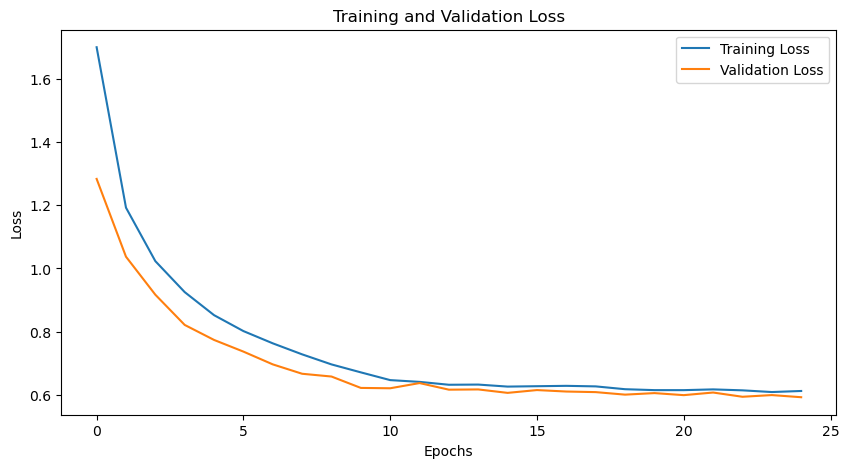

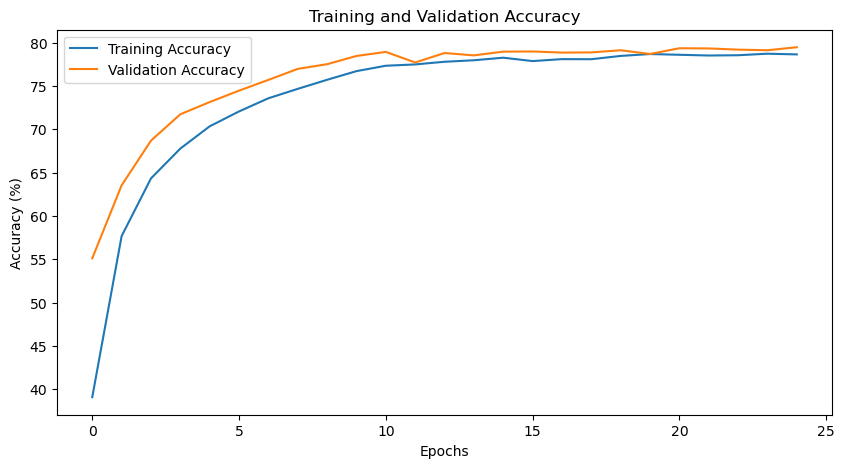

In [15]:
from torchvision.models import efficientnet_b0

# Define EfficientNet model
efficientnet = efficientnet_b0(pretrained=True)
efficientnet.classifier[1] = nn.Linear(efficientnet.classifier[1].in_features, 10)  # Replace classifier with CIFAR-10 classes

# Define Loss Function and Optimizer
criterion = nn.CrossEntropyLoss()  # Cross-entropy loss for multi-class classification
optimizer = optim.SGD(efficientnet.parameters(), lr=0.001, momentum=0.9)  # SGD optimizer with momentum

# Define learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

# Early stopping setup
early_stopping_patience = 5
best_validation_loss = float('inf')
stopping_counter = 0

# Training loop
def training_model(model, optimizer, scheduler, epochs=25):
    training_accuracy_history = []
    validation_accuracy_history = []
    training_loss_history = []
    validation_loss_history = []

    device_test = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device_test)

    starting_time = time.time()

    best_accuracy = 0.0
    global stopping_counter, best_validation_loss

    for epoch in range(epochs):
        model.train()
        run_loss = 0.0
        correct_train = 0
        total_train = 0

        for data in trainloader:
            input_train, label_train = data
            input_train, label_train = input_train.to(device_test), label_train.to(device_test)
            optimizer.zero_grad()

            output_train = model(input_train)
            loss_train = criterion(output_train, label_train)
            loss_train.backward()
            optimizer.step()

            run_loss += loss_train.item()
            _, predicted_train = torch.max(output_train.data, 1)
            total_train += label_train.size(0)
            correct_train += (predicted_train == label_train).sum().item()

        training_loss = run_loss / len(trainloader)
        training_accuracy = 100 * correct_train / total_train
        training_loss_history.append(training_loss)
        training_accuracy_history.append(training_accuracy)

        # Validation
        model.eval()
        vali_correct = 0
        vali_total = 0
        validation_loss = 0.0

        with torch.no_grad():
            for data in testloader:
                vali_input, vali_label = data
                vali_input, vali_label = vali_input.to(device_test), vali_label.to(device_test)
                vali_output = model(vali_input)
                vali_loss = criterion(vali_output, vali_label)
                validation_loss += vali_loss.item()
                _, predicted_vali = torch.max(vali_output.data, 1)
                vali_total += vali_label.size(0)
                vali_correct += (predicted_vali == vali_label).sum().item()

        validation_loss /= len(testloader)
        vali_accuracy = 100 * vali_correct / vali_total
        validation_loss_history.append(validation_loss)
        validation_accuracy_history.append(vali_accuracy)

        print(f'Epoch Count [{epoch + 1}/{epochs}], '
              f'Training Loss: {training_loss:.4f}, '
              f'Training Accuracy: {training_accuracy:.2f}%, '
              f'Validation Loss: {validation_loss:.4f}, '
              f'Validation Accuracy: {vali_accuracy:.2f}%')

        # Check for early stopping
        if validation_loss < best_validation_loss:
            best_validation_loss = validation_loss
            stopping_counter = 0
            # Save best model
            torch.save(model.state_dict(), 'efficientnet_best.pth')
        else:
            stopping_counter += 1

        if stopping_counter >= early_stopping_patience:
            print("Early stopping triggered.")
            break

        # Step the scheduler
        scheduler.step()

    ending_time = time.time()  # Record the end time
    total_elapsed_time = ending_time - starting_time  # Calculate elapsed time

    print(f'The training time is : {total_elapsed_time:.2f} seconds')  # Print the training time

    return training_accuracy_history, training_loss_history, validation_accuracy_history, validation_loss_history

# Training the EfficientNet model
training_accuracy_history, training_loss_history, validation_accuracy_history, validation_loss_history = training_model(efficientnet, optimizer, scheduler)

# Plot Training and Validation Loss
plt.figure(figsize=(10, 5))
plt.plot(training_loss_history, label='Training Loss')
plt.plot(validation_loss_history, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

# Plot Training and Validation Accuracy
plt.figure(figsize=(10, 5))
plt.plot(training_accuracy_history, label='Training Accuracy')
plt.plot(validation_accuracy_history, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()


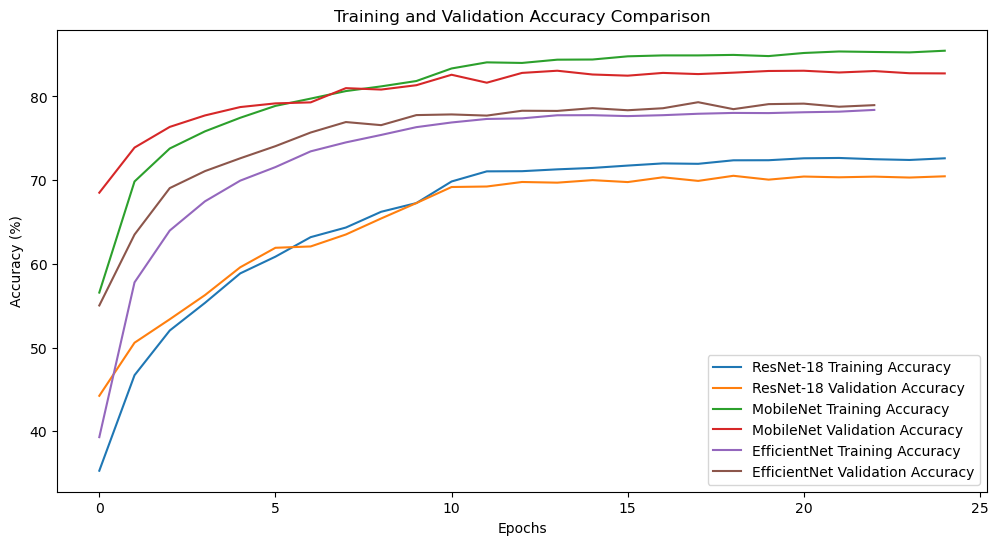

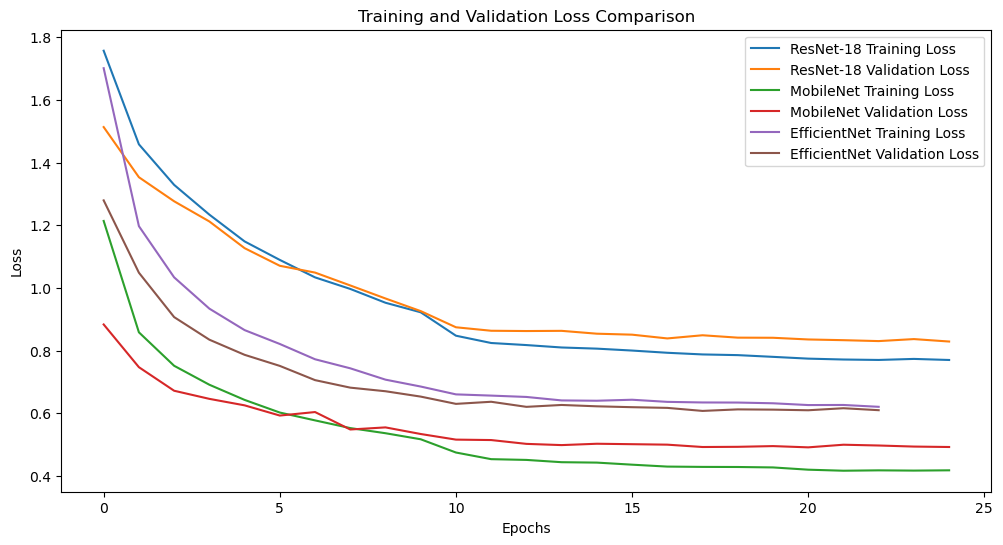

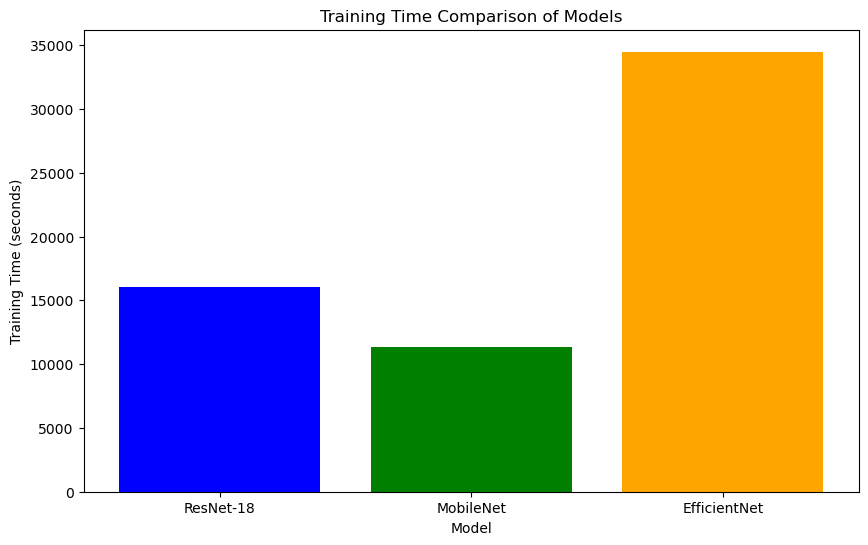

In [16]:
import matplotlib.pyplot as plt

# Training history data for ResNet-18, MobileNet, and EfficientNet
# Values taken from provided results
resnet18_accuracy = [35.29, 46.70, 52.04, 55.34, 58.86, 60.86, 63.19, 64.34, 66.22, 67.26, 69.84, 71.05, 71.07, 71.29, 71.46, 71.74, 72.00, 71.95, 72.37, 72.38, 72.61, 72.65, 72.50, 72.41, 72.61]
resnet18_val_accuracy = [44.24, 50.58, 53.38, 56.27, 59.59, 61.92, 62.08, 63.51, 65.42, 67.26, 69.18, 69.24, 69.78, 69.70, 70.00, 69.77, 70.34, 69.91, 70.52, 70.06, 70.43, 70.34, 70.42, 70.31, 70.46]

mobilenet_accuracy = [56.57, 69.84, 73.78, 75.83, 77.45, 78.87, 79.74, 80.64, 81.20, 81.84, 83.34, 84.07, 84.00, 84.39, 84.41, 84.79, 84.90, 84.90, 84.96, 84.82, 85.19, 85.37, 85.31, 85.26, 85.46]
mobilenet_val_accuracy = [68.50, 73.89, 76.36, 77.73, 78.73, 79.17, 79.29, 80.99, 80.82, 81.34, 82.59, 81.64, 82.81, 83.07, 82.62, 82.48, 82.81, 82.67, 82.84, 83.04, 83.07, 82.86, 83.03, 82.77, 82.75]

efficientnet_accuracy = [39.30, 57.79, 63.98, 67.47, 69.94, 71.56, 73.44, 74.51, 75.40, 76.33, 76.89, 77.31, 77.38, 77.75, 77.76, 77.65, 77.76, 77.93, 78.03, 78.01, 78.11, 78.18, 78.39]
efficientnet_val_accuracy = [55.03, 63.50, 69.05, 71.08, 72.61, 74.06, 75.69, 76.94, 76.57, 77.77, 77.85, 77.71, 78.29, 78.27, 78.60, 78.35, 78.59, 79.31, 78.48, 79.08, 79.14, 78.77, 78.96]

# Plot Training and Validation Accuracy for each model
plt.figure(figsize=(12, 6))
plt.plot(resnet18_accuracy, label='ResNet-18 Training Accuracy')
plt.plot(resnet18_val_accuracy, label='ResNet-18 Validation Accuracy')
plt.plot(mobilenet_accuracy, label='MobileNet Training Accuracy')
plt.plot(mobilenet_val_accuracy, label='MobileNet Validation Accuracy')
plt.plot(efficientnet_accuracy, label='EfficientNet Training Accuracy')
plt.plot(efficientnet_val_accuracy, label='EfficientNet Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy Comparison')
plt.legend()
plt.show()

# Training and Validation Loss Data for ResNet-18, MobileNet, and EfficientNet
resnet18_loss = [1.7570, 1.4582, 1.3288, 1.2338, 1.1483, 1.0892, 1.0335, 0.9966, 0.9525, 0.9220, 0.8473, 0.8240, 0.8174, 0.8097, 0.8060, 0.7999, 0.7928, 0.7875, 0.7853, 0.7798, 0.7741, 0.7713, 0.7699, 0.7732, 0.7698]
resnet18_val_loss = [1.5133, 1.3532, 1.2764, 1.2120, 1.1268, 1.0705, 1.0488, 1.0077, 0.9661, 0.9258, 0.8742, 0.8631, 0.8622, 0.8628, 0.8537, 0.8506, 0.8386, 0.8487, 0.8411, 0.8407, 0.8353, 0.8330, 0.8301, 0.8365, 0.8287]

mobilenet_loss = [1.2136, 0.8581, 0.7513, 0.6908, 0.6424, 0.6020, 0.5770, 0.5524, 0.5360, 0.5167, 0.4744, 0.4532, 0.4508, 0.4435, 0.4422, 0.4356, 0.4295, 0.4285, 0.4282, 0.4268, 0.4196, 0.4163, 0.4175, 0.4167, 0.4176]
mobilenet_val_loss = [0.8832, 0.7468, 0.6716, 0.6457, 0.6250, 0.5924, 0.6036, 0.5479, 0.5546, 0.5335, 0.5156, 0.5142, 0.5020, 0.4981, 0.5024, 0.5010, 0.4995, 0.4920, 0.4926, 0.4949, 0.4909, 0.4993, 0.4968, 0.4934, 0.4920]

efficientnet_loss = [1.7012, 1.1970, 1.0336, 0.9337, 0.8652, 0.8209, 0.7721, 0.7432, 0.7070, 0.6850, 0.6600, 0.6561, 0.6518, 0.6407, 0.6397, 0.6429, 0.6361, 0.6342, 0.6339, 0.6316, 0.6259, 0.6262, 0.6203]
efficientnet_val_loss = [1.2793, 1.0484, 0.9067, 0.8346, 0.7863, 0.7509, 0.7055, 0.6815, 0.6700, 0.6529, 0.6297, 0.6364, 0.6202, 0.6262, 0.6219, 0.6191, 0.6169, 0.6072, 0.6121, 0.6113, 0.6093, 0.6158, 0.6095]

# Plot Training and Validation Loss for each model
plt.figure(figsize=(12, 6))
plt.plot(resnet18_loss, label='ResNet-18 Training Loss')
plt.plot(resnet18_val_loss, label='ResNet-18 Validation Loss')
plt.plot(mobilenet_loss, label='MobileNet Training Loss')
plt.plot(mobilenet_val_loss, label='MobileNet Validation Loss')
plt.plot(efficientnet_loss, label='EfficientNet Training Loss')
plt.plot(efficientnet_val_loss, label='EfficientNet Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Comparison')
plt.legend()
plt.show()

# Training Time Comparison
training_times = [16018, 11331, 34488]  # ResNet-18, MobileNet, EfficientNet
models = ['ResNet-18', 'MobileNet', 'EfficientNet']

plt.figure(figsize=(10, 6))
plt.bar(models, training_times, color=['blue', 'green', 'orange'])
plt.xlabel('Model')
plt.ylabel('Training Time (seconds)')
plt.title('Training Time Comparison of Models')
plt.show()
